In [2]:
from IPython.utils import io
import numpy as np
import collections

from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.utils import shuffle

import scipy.io
from scipy import signal,integrate
import matplotlib.pyplot as plt

import keras
from keras.models import Model
from keras.layers import Input,Dense,LSTM,Dropout

import mne 
import math

import pickle

n_sec=60
n_seg=2*n_sec-1
n_points=n_sec*128
bottleneck=12

In [3]:
pyt=pickle.load(open('DEAP/s01.dat','rb'),encoding='latin1')
#taking only 32 channels(eeg ones) into account #disregarding the first three seconds of each trial
data=pyt['data'][:,0:32,3*128:]
labels=pyt['labels'][:,:3]
single_data=data[0]

#changing to mne format('biosemi32' used in the dataset)
biosemi32_format=mne.channels.make_standard_montage('biosemi32')
#create a basic info instance suitable to use with create_raw
info=mne.create_info(ch_names=biosemi32_format.ch_names, ch_types='eeg',sfreq=128)
#for evoked data of the first trial
raw=mne.EvokedArray(single_data,info)

print(data.shape)
print(labels.shape)
print(np.amax(data))
print(np.amin(data))

(40, 32, 7680)
(40, 3)
126.13356159993128
-93.12451745086868


Creating RawArray with float64 data, n_channels=32, n_times=1
    Range : 0 ... 0 =      0.000 ...     0.000 secs
Ready.


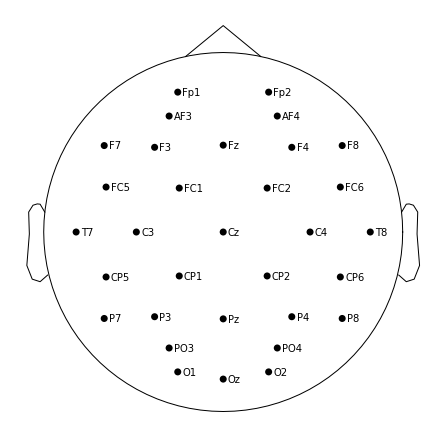

In [35]:
biosemi32_format.plot(kind='topomap',show_names=True);

In [42]:
ten_twenty_montage = mne.channels.make_standard_montage(biosemi32_format)
fig = ten_twenty_montage.plot(kind='3d')
fig.gca().view_init(azim=160, elev=45)  # set view angle
ten_twenty_montage.plot(kind='topomap', show_names=False);

TypeError: kind must be an instance of str, got <class 'mne.channels.montage.DigMontage'> instead.

Creating RawArray with float64 data, n_channels=16, n_times=7680
    Range : 0 ... 7679 =      0.000 ...    59.992 secs
Ready.
Using matplotlib as 2D backend.
Opening raw-browser...


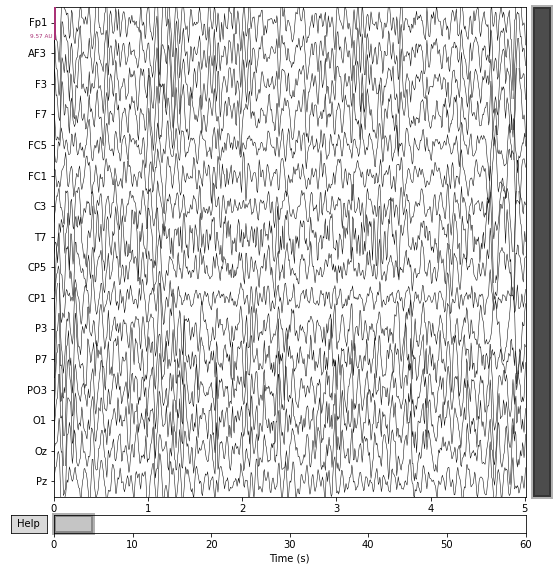

In [5]:
single_data1=data[0,:16]
info1=mne.create_info(ch_names=['Fp1','AF3','F3','F7','FC5','FC1','C3','T7','CP5','CP1','P3','P7','PO3','O1','Oz','Pz'],sfreq=128)
raw1=mne.io.RawArray(single_data1,info1,first_samp=0,copy='auto',verbose=None)
raw1.plot(duration=5,n_channels=16);

Creating RawArray with float64 data, n_channels=1, n_times=7680
    Range : 30 ... 7709 =      0.234 ...    60.227 secs
Ready.
Opening raw-browser...


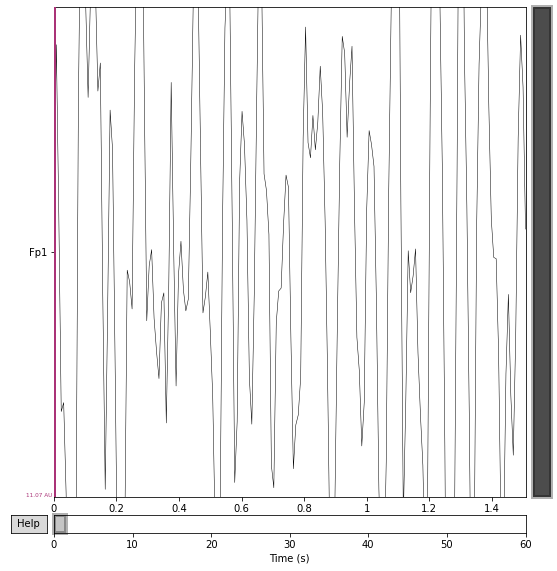

In [28]:
single_data1=data[0,2:3]
info1=mne.create_info(ch_names=['Fp1'],sfreq=128)
raw1=mne.io.RawArray(single_data1,info1,first_samp=30.01,copy='auto',verbose=None)
raw1.plot(duration=1.5,n_channels=1);

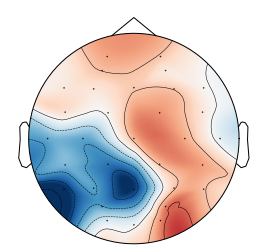

In [31]:
raw=raw.set_montage(biosemi32_format)
mne.viz.plot_topomap(raw.data[:,0],raw.info,show=False);

No projector specified for this dataset. Please consider the method self.add_proj.


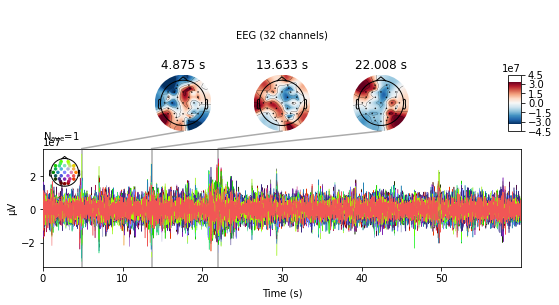

In [33]:
times=np.arange(30.01,30.21,0.01)
raw.plot_joint(picks='eeg');

In [7]:
def convertOneSubjectData(fileName):
    pth=pickle.load(open(fileName,'rb'),encoding='latin1')
    labels=pth['labels'][:,0:3]#valence arousal and dominance
    data=pth['data'][:,0:32,3*128:]# only first 32 channels ['Fp1','AF3','F3','F7','FC5',
    #'FC1','C3','T7','CP5','CP1','P3','P7','PO3','O1','Oz','Pz','Fp2','AF4','Fz','F4',
    #'F8','FC6','FC2','Cz','C4','T8','CP6','CP2','P4','P8','PO4','O2']
    valence_labels,valence_data=[],[]
    arousal_labels,arousal_data=[],[]
    dominance_labels,dominance_data=[],[]
    
    for i, label in enumerate(labels):
        valence,arousal,dominance=label[0],label[1],label[2]
        if(valence>5):
            valence_labels.append(1)
            valence_data.append(data[i])
        if(valence<4):
            valence_labels.append(0)
            valence_data.append(data[i])
        if arousal > 5:
            arousal_labels.append(1)
            arousal_data.append(data[i])
        if arousal < 4:
            arousal_labels.append(0)
            arousal_data.append(data[i])
        if dominance <4:
            dominance_labels.append(0)
            dominance_data.append(data[i])
        if(dominance >5):
            dominance_labels.append(0)
            dominance_data.append(data[i])
            
    print("valence:",len(valence_labels),"arousal: ",len(arousal_labels),"dominance : ",len(dominance_labels));
    return valence_labels,valence_data,arousal_labels,arousal_data,dominance_labels,dominance_data;

In [8]:
def standardize(a,multiple):
    std=np.std(a)
    mean=np.mean(a)
    a=(a-mean)/std
    return multiple*a

In [9]:
def convertAllData():
    valence_labels_all,valence_data_all=[],[]
    arousal_labels_all,arousal_data_all=[],[]
    dominance_labels_all,dominance_data_all=[],[]
    
    for i in range(32):
        if(i<9):
            file="0"+str(i+1)
        else:
            file=str(i+1)
        file_name='DEAP/s'+file+'.dat'
        print(file_name)
        valence_labels,valence_data,arousal_labels,arousal_data,dominance_labels,dominance_data=convertOneSubjectData(file_name)
        valence_labels_all+=valence_labels
        for d in valence_data:
            d=standardize(d,1)
            valence_data_all.append(d)
        arousal_labels_all+=arousal_labels
        for d in arousal_data:
            d=standardize(d,1)
            arousal_data_all.append(d)
        dominance_labels_all+=dominance_labels
        for d in dominance_data:
            d=standardize(d,1)
            dominance_data_all.append(d)
        
    valence_labels_all=np.array(valence_labels_all)
    valence_data_all=np.array(valence_data_all)
    arousal_labels_all=np.array(arousal_labels_all)
    arousal_data_all=np.array(arousal_data_all)
    dominance_labels_all=np.array(dominance_labels_all)
    dominance_data_all=np.array(dominance_data_all)
    
    print("Valence trial data for all subject: ", valence_labels_all.shape,valence_data_all.shape)
    print("Arousal trial data for all subject: ", arousal_labels_all.shape,arousal_data_all.shape)
    print("Dominance trial data fro all subject:",dominance_labels_all.shape,dominance_data_all.shape)
    
    # save numpy array of total data to files
    np.save('DEAP/valence/' + 'all_valence_labels.npy',valence_labels_all)
    np.save('DEAP/valence/' + 'all_valence_data.npy', valence_data_all)
    np.save('DEAP/arousal/' + 'all_arousal_labels.npy',arousal_labels_all)
    np.save('DEAP/arousal/' + 'all_arousal_data.npy', arousal_data_all)
    np.save('DEAP/dominance/' + 'all_dominance_labels.npy',dominance_labels_all)
    np.save('DEAP/dominance/' + 'all_dominance_data.npy', dominance_data_all)

In [10]:
convertAllData()

DEAP/s01.dat
valence: 37 arousal:  39 dominance :  38
DEAP/s02.dat
valence: 31 arousal:  37 dominance :  38
DEAP/s03.dat
valence: 27 arousal:  32 dominance :  27
DEAP/s04.dat
valence: 36 arousal:  37 dominance :  33
DEAP/s05.dat
valence: 33 arousal:  28 dominance :  34
DEAP/s06.dat
valence: 35 arousal:  32 dominance :  37
DEAP/s07.dat
valence: 37 arousal:  35 dominance :  38
DEAP/s08.dat
valence: 30 arousal:  30 dominance :  36
DEAP/s09.dat
valence: 32 arousal:  25 dominance :  29
DEAP/s10.dat
valence: 33 arousal:  34 dominance :  33
DEAP/s11.dat
valence: 35 arousal:  36 dominance :  36
DEAP/s12.dat
valence: 36 arousal:  38 dominance :  39
DEAP/s13.dat
valence: 30 arousal:  37 dominance :  36
DEAP/s14.dat
valence: 39 arousal:  38 dominance :  37
DEAP/s15.dat
valence: 32 arousal:  29 dominance :  33
DEAP/s16.dat
valence: 35 arousal:  38 dominance :  34
DEAP/s17.dat
valence: 31 arousal:  34 dominance :  35
DEAP/s18.dat
valence: 28 arousal:  30 dominance :  36
DEAP/s19.dat
valence: 35 aro

In [11]:
def load_data(dim):
    if dim=='valence':
        labels_all=np.load('DEAP/valence/' + 'all_valence_labels.npy',allow_pickle=True)
        data_all=np.load('DEAP/valence/' + 'all_valence_data.npy',allow_pickle=True)
        print("Valence :",labels_all.shape,data_all.shape)
    elif dim=='arousal':
        labels_all=np.load('DEAP/arousal/'+'all_arousal_labels.npy',allow_pickle=True)
        data_all=np.load('DEAP/arousal/'+'all_arousal_data.npy',allow_pickle=True)
        print("Arousal: ",labels_all.shape,data_all.shape)
    elif dim=='dominance':
        labels_all=np.load('DEAP/dominance/all_dominance_labels.npy',allow_pickle=True)
        data_all=np.load('DEAP/dominance/all_dominance_data.npy',allow_pickle=True)
        print("Dominance: ",labels_all.shape,data_all.shape) 
    return labels_all,data_all

In [12]:
labels_all_val,data_all_val=load_data(dim='valence')

Valence : (1064,) (1064, 32, 7680)


In [13]:
labels_all_ar,data_all_ar=load_data(dim='arousal')

Arousal:  (1105,) (1105, 32, 7680)


In [14]:
labels_all_dom,data_all_dom=load_data(dim='dominance')

Dominance:  (1122,) (1122, 32, 7680)


In [15]:
print(np.amax(data_all_ar))
print(np.amin(data_all_ar))

91.75265724740024
-100.00674912321686


In [16]:
#Feature extraction using PSD
def PSD_extraction(data):
    info = mne.create_info(ch_names=['1','2','3','4','5','6','7','8','9','10','11','12'],sfreq=128);
    raw=mne.io.RawArray(data,info,first_samp=0,copy='auto',verbose=None);
    psd_origin, f=mne.time_frequency.psd_welch(raw,fmin=0,fmax=60,n_fft=128,n_overlap=64,n_per_seg=128,picks='all',window='hann',average=None)
    psd=np.moveaxis(psd_origin,-1,0)
    band_power=[]
    for segment in psd:
        segment_band_p=[]#band power for all channels in one segment
        for psd_channel in segment:
            y_int=integrate.cumtrapz(psd_channel,f,initial=0)#integrate this to calculate bandpower
            one_band_p=np.array([y_int[7]-y_int[4],y_int[13]-y_int[8],y_int[30]-y_int[14],y_int[51]-y_int[31]])
            segment_band_p.append(one_band_p)
        band_power.append(segment_band_p)
    band_power=np.array(band_power)
    band_power=np.moveaxis(band_power,-1,1)
    band_power=band_power.reshape((n_seg,bottleneck*4))
    band_power=10*band_power
    return band_power
    

In [17]:
#code for transforming eeg data shape
def vector_transform(data):
    vectors = np.moveaxis(data, 1, -1)
    vectors = vectors.reshape((vectors.shape[0]*vectors.shape[1], vectors.shape[2]))
    return vectors
def inverse_vector_transform(vectors):
    data = vectors.reshape((int(vectors.shape[0]/n_points), n_points, vectors.shape[1]))
    data = np.moveaxis(data, -1, 1)
    return data

In [18]:
#10 fold cross verification(dividing the data so that it beconmes a multiple of 10)
data_all,labels_all=shuffle(data_all_ar,labels_all_ar,random_state=42)
n=len(labels_all)
print(n)
fold_n=math.floor(n/10)
print(fold_n)
data_all,labels_all=data_all[:10*fold_n],labels_all[:10*fold_n]
print(data_all.shape)
print(labels_all.shape)

1105
110
(1100, 32, 7680)
(1100,)


In [19]:
def process(test_fold_number):
    train_data=np.concatenate((data_all[:test_fold_number*fold_n],data_all[fold_n+test_fold_number*fold_n:]),axis=0)
    train_labels=np.concatenate((labels_all[:test_fold_number*fold_n],labels_all[fold_n+test_fold_number*fold_n:]),axis=0)
    test_data=data_all[test_fold_number*fold_n:fold_n+test_fold_number*fold_n]
    test_labels=labels_all[test_fold_number*fold_n:fold_n+test_fold_number*fold_n]
    print(train_data.shape,test_data.shape)
    
    #changing dimension to 32 dimension vector for input to autoencoder
    train_vectors=vector_transform(train_data)
    test_vectors=vector_transform(test_data)
    print(train_vectors.shape,test_vectors.shape)
    
    #create new autoencoder
    input_=Input(shape=(32,))
    encoded=Dense(64,activation=None)(input_)
    bottleneck_layer=Dense(bottleneck,activation=None)(encoded)
    decoded=Dense(64,activation=None)(bottleneck_layer)
    decoded=Dense(32,activation=None)(decoded)
    autoencoder=Model(input_,decoded)
    
    encoder=Model(input_,bottleneck_layer)
    
    decoder_input_layer=Input(shape=(bottleneck,))
    decoder_layer=autoencoder.layers[-2](decoder_input_layer)
    decoder_layer=autoencoder.layers[-1](decoder_layer)
    decoder=Model(decoder_input_layer,decoder_layer)
    
    #compile and train autoencoder
    autoencoder.compile(optimizer='SGD', loss='mse', metrics=['accuracy'])
    autoencoder.fit(train_vectors, train_vectors, epochs=1, batch_size=64, shuffle=True, validation_data=(test_vectors, test_vectors))
    autoencoder.save("../Results/autoencoder_model/autoencoder_model_test_fold_" + str(test_fold_number))
    
    # -------- Encode train and test data by pass through encoder --------
    train_data_encoded = encoder.predict(train_vectors)
    train_data_encoded = inverse_vector_transform(train_data_encoded) 
    test_data_encoded = encoder.predict(test_vectors) 
    test_data_encoded = inverse_vector_transform(test_data_encoded) 
    print("Encoded training data shape: ", train_data_encoded.shape)
    print("Encoded test data shape: ", test_data_encoded.shape)
    
    # -------- Feature extraction from 12 source signal --------
    train_band_power = [] # band power feature sequence for train trials
    for data in train_data_encoded: # for every train trial
        with io.capture_output() as captured:
            trial_band_power = PSD_extraction(data) # data shape (12, 8064)
        train_band_power.append(trial_band_power)
    train_band_power = np.array(train_band_power)
    
    test_band_power = [] # band power feature sequence for test trials
    for data in test_data_encoded: # for every test trial
        with io.capture_output() as captured:
            trial_band_power = PSD_extraction(data) # data shape (12, 8064)
        test_band_power.append(trial_band_power)
    test_band_power = np.array(test_band_power)
    print("All features of training data shape: ", train_band_power.shape) # shape (849, 125, 48)
    print("All features of test data shape: ", test_band_power.shape) # shape (95, 125, 48)
    
    # -------- Create new LSTM model --------
    x=Input(shape=(n_seg,bottleneck*4)) # flatten (12,4) to 48
    x1=LSTM(n_seg)(x)
    x2=Dense(n_seg)(x1)
    x3=Dense(12)(x2)
    output=Dense(1, activation="sigmoid")(x2)
    model=Model(x, output)
    print(train_band_power.shape,train_labels.shape,test_band_power.shape,test_labels.shape)

    # -------- Compile and train LSTM --------
    model.compile(optimizer='SGD', loss='mse', metrics=['accuracy'])
    history = model.fit(train_band_power, train_labels, epochs=30, validation_data=(test_band_power, test_labels))
    print("Hightest accuracy: " + str(max(history.history['val_accuracy'])))
    model.save("../Results/LSTM_model/LSTM_model_test_fold_" + str(test_fold_number))    

In [20]:
for i in range(10):
    print("********** Test Fold " + str(i) + " ************")
    process(i)

********** Test Fold 0 ************
(990, 32, 7680) (110, 32, 7680)
(7603200, 32) (844800, 32)
118800/118800 [==============================] - 213s 2ms/step - loss: 0.2261 - accuracy: 0.4446 - val_loss: 0.2193 - val_accuracy: 0.4685
INFO:tensorflow:Assets written to: ../Results/autoencoder_model/autoencoder_model_test_fold_0\assets
Encoded training data shape:  (990, 12, 7680)
Encoded test data shape:  (110, 12, 7680)
All features of training data shape:  (990, 119, 48)
All features of test data shape:  (110, 119, 48)
(990, 119, 48) (990,) (110, 119, 48) (110,)
Epoch 1/30
31/31 [==============================] - 5s 76ms/step - loss: 0.2423 - accuracy: 0.5929 - val_loss: 0.2609 - val_accuracy: 0.5727
Epoch 2/30
31/31 [==============================] - 2s 61ms/step - loss: 0.2277 - accuracy: 0.6475 - val_loss: 0.2568 - val_accuracy: 0.6182
Epoch 3/30
31/31 [==============================] - 2s 66ms/step - loss: 0.2218 - accuracy: 0.6576 - val_loss: 0.2532 - val_accuracy: 0.6182
Epoch 4/

INFO:tensorflow:Assets written to: ../Results/LSTM_model/LSTM_model_test_fold_0\assets


INFO:tensorflow:Assets written to: ../Results/LSTM_model/LSTM_model_test_fold_0\assets


********** Test Fold 1 ************
(990, 32, 7680) (110, 32, 7680)
(7603200, 32) (844800, 32)
118800/118800 [==============================] - 177s 1ms/step - loss: 0.2249 - accuracy: 0.4484 - val_loss: 0.2286 - val_accuracy: 0.4371
INFO:tensorflow:Assets written to: ../Results/autoencoder_model/autoencoder_model_test_fold_1\assets


INFO:tensorflow:Assets written to: ../Results/autoencoder_model/autoencoder_model_test_fold_1\assets


Encoded training data shape:  (990, 12, 7680)
Encoded test data shape:  (110, 12, 7680)
All features of training data shape:  (990, 119, 48)
All features of test data shape:  (110, 119, 48)
(990, 119, 48) (990,) (110, 119, 48) (110,)
Epoch 1/30
31/31 [==============================] - 5s 84ms/step - loss: 0.2348 - accuracy: 0.6131 - val_loss: 0.2256 - val_accuracy: 0.6818
Epoch 2/30
31/31 [==============================] - 2s 67ms/step - loss: 0.2181 - accuracy: 0.6646 - val_loss: 0.2230 - val_accuracy: 0.6545
Epoch 3/30
31/31 [==============================] - 2s 73ms/step - loss: 0.2105 - accuracy: 0.6758 - val_loss: 0.2229 - val_accuracy: 0.6636
Epoch 4/30
31/31 [==============================] - 2s 69ms/step - loss: 0.2050 - accuracy: 0.6879 - val_loss: 0.2222 - val_accuracy: 0.6636
Epoch 5/30
31/31 [==============================] - 2s 73ms/step - loss: 0.2007 - accuracy: 0.6939 - val_loss: 0.2231 - val_accuracy: 0.6545
Epoch 6/30
31/31 [==============================] - 2s 67ms/s

INFO:tensorflow:Assets written to: ../Results/LSTM_model/LSTM_model_test_fold_1\assets


INFO:tensorflow:Assets written to: ../Results/LSTM_model/LSTM_model_test_fold_1\assets


********** Test Fold 2 ************
(990, 32, 7680) (110, 32, 7680)
(7603200, 32) (844800, 32)
118800/118800 [==============================] - 157s 1ms/step - loss: 0.2266 - accuracy: 0.4466 - val_loss: 0.2194 - val_accuracy: 0.4608
INFO:tensorflow:Assets written to: ../Results/autoencoder_model/autoencoder_model_test_fold_2\assets


INFO:tensorflow:Assets written to: ../Results/autoencoder_model/autoencoder_model_test_fold_2\assets


Encoded training data shape:  (990, 12, 7680)
Encoded test data shape:  (110, 12, 7680)
All features of training data shape:  (990, 119, 48)
All features of test data shape:  (110, 119, 48)
(990, 119, 48) (990,) (110, 119, 48) (110,)
Epoch 1/30
31/31 [==============================] - 6s 108ms/step - loss: 0.2605 - accuracy: 0.5020 - val_loss: 0.2449 - val_accuracy: 0.5909
Epoch 2/30
31/31 [==============================] - 3s 88ms/step - loss: 0.2220 - accuracy: 0.6657 - val_loss: 0.2399 - val_accuracy: 0.6000
Epoch 3/30
31/31 [==============================] - 3s 86ms/step - loss: 0.2132 - accuracy: 0.6687 - val_loss: 0.2372 - val_accuracy: 0.6091
Epoch 4/30
31/31 [==============================] - 3s 86ms/step - loss: 0.2079 - accuracy: 0.6747 - val_loss: 0.2330 - val_accuracy: 0.6182
Epoch 5/30
31/31 [==============================] - 3s 86ms/step - loss: 0.2043 - accuracy: 0.6808 - val_loss: 0.2308 - val_accuracy: 0.6091
Epoch 6/30
31/31 [==============================] - 3s 87ms/

INFO:tensorflow:Assets written to: ../Results/LSTM_model/LSTM_model_test_fold_2\assets


INFO:tensorflow:Assets written to: ../Results/LSTM_model/LSTM_model_test_fold_2\assets


********** Test Fold 3 ************
(990, 32, 7680) (110, 32, 7680)
(7603200, 32) (844800, 32)
118800/118800 [==============================] - 189s 2ms/step - loss: 0.2256 - accuracy: 0.4506 - val_loss: 0.2292 - val_accuracy: 0.4524
INFO:tensorflow:Assets written to: ../Results/autoencoder_model/autoencoder_model_test_fold_3\assets


INFO:tensorflow:Assets written to: ../Results/autoencoder_model/autoencoder_model_test_fold_3\assets


Encoded training data shape:  (990, 12, 7680)
Encoded test data shape:  (110, 12, 7680)
All features of training data shape:  (990, 119, 48)
All features of test data shape:  (110, 119, 48)
(990, 119, 48) (990,) (110, 119, 48) (110,)
Epoch 1/30
31/31 [==============================] - 6s 120ms/step - loss: 0.2367 - accuracy: 0.6051 - val_loss: 0.2295 - val_accuracy: 0.6364
Epoch 2/30
31/31 [==============================] - 3s 97ms/step - loss: 0.2207 - accuracy: 0.6475 - val_loss: 0.2282 - val_accuracy: 0.6909
Epoch 3/30
31/31 [==============================] - 3s 98ms/step - loss: 0.2122 - accuracy: 0.6626 - val_loss: 0.2252 - val_accuracy: 0.6727
Epoch 4/30
31/31 [==============================] - 3s 101ms/step - loss: 0.2066 - accuracy: 0.6848 - val_loss: 0.2251 - val_accuracy: 0.6727
Epoch 5/30
31/31 [==============================] - 3s 98ms/step - loss: 0.2025 - accuracy: 0.6919 - val_loss: 0.2235 - val_accuracy: 0.6636
Epoch 6/30
31/31 [==============================] - 3s 99ms

INFO:tensorflow:Assets written to: ../Results/LSTM_model/LSTM_model_test_fold_3\assets


INFO:tensorflow:Assets written to: ../Results/LSTM_model/LSTM_model_test_fold_3\assets


********** Test Fold 4 ************
(990, 32, 7680) (110, 32, 7680)
(7603200, 32) (844800, 32)
118800/118800 [==============================] - 202s 2ms/step - loss: 0.2248 - accuracy: 0.4481 - val_loss: 0.2281 - val_accuracy: 0.4425
INFO:tensorflow:Assets written to: ../Results/autoencoder_model/autoencoder_model_test_fold_4\assets


INFO:tensorflow:Assets written to: ../Results/autoencoder_model/autoencoder_model_test_fold_4\assets


Encoded training data shape:  (990, 12, 7680)
Encoded test data shape:  (110, 12, 7680)
All features of training data shape:  (990, 119, 48)
All features of test data shape:  (110, 119, 48)
(990, 119, 48) (990,) (110, 119, 48) (110,)
Epoch 1/30
31/31 [==============================] - 7s 133ms/step - loss: 0.2444 - accuracy: 0.5677 - val_loss: 0.2180 - val_accuracy: 0.6545
Epoch 2/30
31/31 [==============================] - 3s 106ms/step - loss: 0.2228 - accuracy: 0.6566 - val_loss: 0.2156 - val_accuracy: 0.6727
Epoch 3/30
31/31 [==============================] - 3s 107ms/step - loss: 0.2156 - accuracy: 0.6687 - val_loss: 0.2179 - val_accuracy: 0.6636
Epoch 4/30
31/31 [==============================] - 3s 109ms/step - loss: 0.2104 - accuracy: 0.6788 - val_loss: 0.2194 - val_accuracy: 0.6636
Epoch 5/30
31/31 [==============================] - 3s 107ms/step - loss: 0.2065 - accuracy: 0.6859 - val_loss: 0.2203 - val_accuracy: 0.6545
Epoch 6/30
31/31 [==============================] - 3s 1

INFO:tensorflow:Assets written to: ../Results/LSTM_model/LSTM_model_test_fold_4\assets


INFO:tensorflow:Assets written to: ../Results/LSTM_model/LSTM_model_test_fold_4\assets


********** Test Fold 5 ************
(990, 32, 7680) (110, 32, 7680)
(7603200, 32) (844800, 32)
118800/118800 [==============================] - 195s 1ms/step - loss: 0.2284 - accuracy: 0.4464 - val_loss: 0.2157 - val_accuracy: 0.4442
INFO:tensorflow:Assets written to: ../Results/autoencoder_model/autoencoder_model_test_fold_5\assets


INFO:tensorflow:Assets written to: ../Results/autoencoder_model/autoencoder_model_test_fold_5\assets


Encoded training data shape:  (990, 12, 7680)
Encoded test data shape:  (110, 12, 7680)
All features of training data shape:  (990, 119, 48)
All features of test data shape:  (110, 119, 48)
(990, 119, 48) (990,) (110, 119, 48) (110,)
Epoch 1/30
31/31 [==============================] - 7s 144ms/step - loss: 0.2383 - accuracy: 0.5970 - val_loss: 0.1985 - val_accuracy: 0.7182
Epoch 2/30
31/31 [==============================] - 4s 118ms/step - loss: 0.2202 - accuracy: 0.6646 - val_loss: 0.1912 - val_accuracy: 0.7091
Epoch 3/30
31/31 [==============================] - 4s 122ms/step - loss: 0.2140 - accuracy: 0.6697 - val_loss: 0.1866 - val_accuracy: 0.7273
Epoch 4/30
31/31 [==============================] - 4s 121ms/step - loss: 0.2089 - accuracy: 0.6778 - val_loss: 0.1841 - val_accuracy: 0.7273
Epoch 5/30
31/31 [==============================] - 4s 122ms/step - loss: 0.2056 - accuracy: 0.6798 - val_loss: 0.1825 - val_accuracy: 0.7455
Epoch 6/30
31/31 [==============================] - 4s 1

INFO:tensorflow:Assets written to: ../Results/LSTM_model/LSTM_model_test_fold_5\assets


INFO:tensorflow:Assets written to: ../Results/LSTM_model/LSTM_model_test_fold_5\assets


********** Test Fold 6 ************
(990, 32, 7680) (110, 32, 7680)
(7603200, 32) (844800, 32)
118800/118800 [==============================] - 189s 1ms/step - loss: 0.2255 - accuracy: 0.4490 - val_loss: 0.2287 - val_accuracy: 0.4532
INFO:tensorflow:Assets written to: ../Results/autoencoder_model/autoencoder_model_test_fold_6\assets


INFO:tensorflow:Assets written to: ../Results/autoencoder_model/autoencoder_model_test_fold_6\assets


Encoded training data shape:  (990, 12, 7680)
Encoded test data shape:  (110, 12, 7680)
All features of training data shape:  (990, 119, 48)
All features of test data shape:  (110, 119, 48)
(990, 119, 48) (990,) (110, 119, 48) (110,)
Epoch 1/30
31/31 [==============================] - 7s 157ms/step - loss: 0.2411 - accuracy: 0.5960 - val_loss: 0.2180 - val_accuracy: 0.6545
Epoch 2/30
31/31 [==============================] - 4s 127ms/step - loss: 0.2169 - accuracy: 0.6657 - val_loss: 0.2114 - val_accuracy: 0.6727
Epoch 3/30
31/31 [==============================] - 4s 127ms/step - loss: 0.2103 - accuracy: 0.6758 - val_loss: 0.2091 - val_accuracy: 0.6636
Epoch 4/30
31/31 [==============================] - 4s 130ms/step - loss: 0.2056 - accuracy: 0.6818 - val_loss: 0.2080 - val_accuracy: 0.6818
Epoch 5/30
31/31 [==============================] - 4s 128ms/step - loss: 0.2019 - accuracy: 0.6879 - val_loss: 0.2064 - val_accuracy: 0.6818
Epoch 6/30
31/31 [==============================] - 4s 1

INFO:tensorflow:Assets written to: ../Results/LSTM_model/LSTM_model_test_fold_6\assets


INFO:tensorflow:Assets written to: ../Results/LSTM_model/LSTM_model_test_fold_6\assets


********** Test Fold 7 ************
(990, 32, 7680) (110, 32, 7680)
(7603200, 32) (844800, 32)
118800/118800 [==============================] - 167s 1ms/step - loss: 0.2236 - accuracy: 0.4530 - val_loss: 0.2414 - val_accuracy: 0.4362
INFO:tensorflow:Assets written to: ../Results/autoencoder_model/autoencoder_model_test_fold_7\assets


INFO:tensorflow:Assets written to: ../Results/autoencoder_model/autoencoder_model_test_fold_7\assets


Encoded training data shape:  (990, 12, 7680)
Encoded test data shape:  (110, 12, 7680)
All features of training data shape:  (990, 119, 48)
All features of test data shape:  (110, 119, 48)
(990, 119, 48) (990,) (110, 119, 48) (110,)
Epoch 1/30
31/31 [==============================] - 8s 177ms/step - loss: 0.2415 - accuracy: 0.5859 - val_loss: 0.2024 - val_accuracy: 0.7091
Epoch 2/30
31/31 [==============================] - 5s 162ms/step - loss: 0.2262 - accuracy: 0.6485 - val_loss: 0.1979 - val_accuracy: 0.7182
Epoch 3/30
31/31 [==============================] - 5s 168ms/step - loss: 0.2182 - accuracy: 0.6667 - val_loss: 0.1929 - val_accuracy: 0.7364
Epoch 4/30
31/31 [==============================] - 5s 164ms/step - loss: 0.2125 - accuracy: 0.6687 - val_loss: 0.1911 - val_accuracy: 0.7455
Epoch 5/30
31/31 [==============================] - 5s 163ms/step - loss: 0.2080 - accuracy: 0.6697 - val_loss: 0.1897 - val_accuracy: 0.7455
Epoch 6/30
31/31 [==============================] - 5s 1

INFO:tensorflow:Assets written to: ../Results/LSTM_model/LSTM_model_test_fold_7\assets


INFO:tensorflow:Assets written to: ../Results/LSTM_model/LSTM_model_test_fold_7\assets


********** Test Fold 8 ************
(990, 32, 7680) (110, 32, 7680)
(7603200, 32) (844800, 32)
118800/118800 [==============================] - 210s 2ms/step - loss: 0.2266 - accuracy: 0.4506 - val_loss: 0.2205 - val_accuracy: 0.4403
INFO:tensorflow:Assets written to: ../Results/autoencoder_model/autoencoder_model_test_fold_8\assets


INFO:tensorflow:Assets written to: ../Results/autoencoder_model/autoencoder_model_test_fold_8\assets


Encoded training data shape:  (990, 12, 7680)
Encoded test data shape:  (110, 12, 7680)
All features of training data shape:  (990, 119, 48)
All features of test data shape:  (110, 119, 48)
(990, 119, 48) (990,) (110, 119, 48) (110,)
Epoch 1/30
31/31 [==============================] - 8s 180ms/step - loss: 0.2483 - accuracy: 0.5636 - val_loss: 0.2179 - val_accuracy: 0.6818
Epoch 2/30
31/31 [==============================] - 5s 154ms/step - loss: 0.2241 - accuracy: 0.6495 - val_loss: 0.2114 - val_accuracy: 0.7000
Epoch 3/30
31/31 [==============================] - 5s 158ms/step - loss: 0.2157 - accuracy: 0.6626 - val_loss: 0.2090 - val_accuracy: 0.7182
Epoch 4/30
31/31 [==============================] - 5s 157ms/step - loss: 0.2094 - accuracy: 0.6687 - val_loss: 0.2077 - val_accuracy: 0.7091
Epoch 5/30
31/31 [==============================] - 5s 153ms/step - loss: 0.2046 - accuracy: 0.6717 - val_loss: 0.2070 - val_accuracy: 0.7000
Epoch 6/30
31/31 [==============================] - 5s 1

INFO:tensorflow:Assets written to: ../Results/LSTM_model/LSTM_model_test_fold_8\assets


INFO:tensorflow:Assets written to: ../Results/LSTM_model/LSTM_model_test_fold_8\assets


********** Test Fold 9 ************
(990, 32, 7680) (110, 32, 7680)
(7603200, 32) (844800, 32)
118800/118800 [==============================] - 228s 2ms/step - loss: 0.2261 - accuracy: 0.4491 - val_loss: 0.2230 - val_accuracy: 0.4549
INFO:tensorflow:Assets written to: ../Results/autoencoder_model/autoencoder_model_test_fold_9\assets


INFO:tensorflow:Assets written to: ../Results/autoencoder_model/autoencoder_model_test_fold_9\assets


Encoded training data shape:  (990, 12, 7680)
Encoded test data shape:  (110, 12, 7680)
All features of training data shape:  (990, 119, 48)
All features of test data shape:  (110, 119, 48)
(990, 119, 48) (990,) (110, 119, 48) (110,)
Epoch 1/30
31/31 [==============================] - 9s 219ms/step - loss: 0.2232 - accuracy: 0.6232 - val_loss: 0.2222 - val_accuracy: 0.6455
Epoch 2/30
31/31 [==============================] - 5s 172ms/step - loss: 0.2111 - accuracy: 0.6737 - val_loss: 0.2209 - val_accuracy: 0.6545
Epoch 3/30
31/31 [==============================] - 6s 190ms/step - loss: 0.2070 - accuracy: 0.6808 - val_loss: 0.2180 - val_accuracy: 0.6545
Epoch 4/30
31/31 [==============================] - 6s 185ms/step - loss: 0.2039 - accuracy: 0.6788 - val_loss: 0.2157 - val_accuracy: 0.6545
Epoch 5/30
31/31 [==============================] - 5s 173ms/step - loss: 0.2010 - accuracy: 0.6828 - val_loss: 0.2142 - val_accuracy: 0.6545
Epoch 6/30
31/31 [==============================] - 5s 1

INFO:tensorflow:Assets written to: ../Results/LSTM_model/LSTM_model_test_fold_9\assets


INFO:tensorflow:Assets written to: ../Results/LSTM_model/LSTM_model_test_fold_9\assets


In [21]:
#10 fold cross verification(dividing the data so that it beconmes a multiple of 10)
data_all,labels_all=shuffle(data_all_val,labels_all_val,random_state=42)
n=len(labels_all)
print(n)
fold_n=math.floor(n/10)
print(fold_n)
data_all,labels_all=data_all[:10*fold_n],labels_all[:10*fold_n]
print(data_all.shape)
print(labels_all.shape)

1064
106
(1060, 32, 7680)
(1060,)


In [22]:
def process(test_fold_number):
    train_data=np.concatenate((data_all[:test_fold_number*fold_n],data_all[fold_n+test_fold_number*fold_n:]),axis=0)
    train_labels=np.concatenate((labels_all[:test_fold_number*fold_n],labels_all[fold_n+test_fold_number*fold_n:]),axis=0)
    test_data=data_all[test_fold_number*fold_n:fold_n+test_fold_number*fold_n]
    test_labels=labels_all[test_fold_number*fold_n:fold_n+test_fold_number*fold_n]
    print(train_data.shape,test_data.shape)
    
    #changing dimension to 32 dimension vector for input to autoencoder
    train_vectors=vector_transform(train_data)
    test_vectors=vector_transform(test_data)
    print(train_vectors.shape,test_vectors.shape)
    
    #create new autoencoder
    input_=Input(shape=(32,))
    encoded=Dense(64,activation=None)(input_)
    bottleneck_layer=Dense(bottleneck,activation=None)(encoded)
    decoded=Dense(64,activation=None)(bottleneck_layer)
    decoded=Dense(32,activation=None)(decoded)
    autoencoder=Model(input_,decoded)
    
    encoder=Model(input_,bottleneck_layer)
    
    decoder_input_layer=Input(shape=(bottleneck,))
    decoder_layer=autoencoder.layers[-2](decoder_input_layer)
    decoder_layer=autoencoder.layers[-1](decoder_layer)
    decoder=Model(decoder_input_layer,decoder_layer)
    
    #compile and train autoencoder
    autoencoder.compile(optimizer='SGD', loss='mse', metrics=['accuracy'])
    autoencoder.fit(train_vectors, train_vectors, epochs=1, batch_size=64, shuffle=True, validation_data=(test_vectors, test_vectors))
    autoencoder.save("../Results/autoencoder_model/autoencoder_model_test_fold_" + str(test_fold_number))
    
    # -------- Encode train and test data by pass through encoder --------
    train_data_encoded = encoder.predict(train_vectors)
    train_data_encoded = inverse_vector_transform(train_data_encoded) 
    test_data_encoded = encoder.predict(test_vectors) 
    test_data_encoded = inverse_vector_transform(test_data_encoded) 
    print("Encoded training data shape: ", train_data_encoded.shape)
    print("Encoded test data shape: ", test_data_encoded.shape)
    
    # -------- Feature extraction from 12 source signal --------
    train_band_power = [] # band power feature sequence for train trials
    for data in train_data_encoded: # for every train trial
        with io.capture_output() as captured:
            trial_band_power = PSD_extraction(data) 
        train_band_power.append(trial_band_power)
    train_band_power = np.array(train_band_power)
    
    test_band_power = [] # band power feature sequence for test trials
    for data in test_data_encoded: # for every test trial
        with io.capture_output() as captured:
            trial_band_power = PSD_extraction(data) 
        test_band_power.append(trial_band_power)
    test_band_power = np.array(test_band_power)
    print("All features of training data shape: ", train_band_power.shape) 
    print("All features of test data shape: ", test_band_power.shape) 
    
    # -------- Create new LSTM model --------
    x=Input(shape=(n_seg,bottleneck*4)) 
    x1=LSTM(n_seg)(x)
    x2=Dense(n_seg)(x1)
    x3=Dense(12)(x2)
    output=Dense(1, activation="sigmoid")(x2)
    model=Model(x, output)
    print(train_band_power.shape,train_labels.shape,test_band_power.shape,test_labels.shape)

    # -------- Compile and train LSTM --------
    model.compile(optimizer='SGD', loss='mse', metrics=['accuracy'])
    history = model.fit(train_band_power, train_labels, epochs=30, validation_data=(test_band_power, test_labels))
    print("Hightest accuracy: " + str(max(history.history['val_accuracy'])))
    model.save("../Results/LSTM_model/LSTM_model_test_fold_" + str(test_fold_number))    

In [23]:
for i in range(10):
    print("********** Test Fold " + str(i) + " ************")
    process(i)

********** Test Fold 0 ************
(954, 32, 7680) (106, 32, 7680)
(7326720, 32) (814080, 32)
114480/114480 [==============================] - 276s 2ms/step - loss: 0.2300 - accuracy: 0.4404 - val_loss: 0.2100 - val_accuracy: 0.4452
INFO:tensorflow:Assets written to: ../Results/autoencoder_model/autoencoder_model_test_fold_0\assets


INFO:tensorflow:Assets written to: ../Results/autoencoder_model/autoencoder_model_test_fold_0\assets


Encoded training data shape:  (954, 12, 7680)
Encoded test data shape:  (106, 12, 7680)
All features of training data shape:  (954, 119, 48)
All features of test data shape:  (106, 119, 48)
(954, 119, 48) (954,) (106, 119, 48) (106,)
Epoch 1/30
30/30 [==============================] - 9s 234ms/step - loss: 0.2441 - accuracy: 0.5964 - val_loss: 0.2428 - val_accuracy: 0.6132
Epoch 2/30
30/30 [==============================] - 6s 204ms/step - loss: 0.2262 - accuracy: 0.6593 - val_loss: 0.2383 - val_accuracy: 0.6321
Epoch 3/30
30/30 [==============================] - 6s 208ms/step - loss: 0.2204 - accuracy: 0.6709 - val_loss: 0.2370 - val_accuracy: 0.6226
Epoch 4/30
30/30 [==============================] - 6s 206ms/step - loss: 0.2167 - accuracy: 0.6719 - val_loss: 0.2366 - val_accuracy: 0.6132
Epoch 5/30
30/30 [==============================] - 6s 212ms/step - loss: 0.2140 - accuracy: 0.6709 - val_loss: 0.2357 - val_accuracy: 0.6226
Epoch 6/30
30/30 [==============================] - 6s 2

INFO:tensorflow:Assets written to: ../Results/LSTM_model/LSTM_model_test_fold_0\assets


INFO:tensorflow:Assets written to: ../Results/LSTM_model/LSTM_model_test_fold_0\assets


********** Test Fold 1 ************
(954, 32, 7680) (106, 32, 7680)
(7326720, 32) (814080, 32)
114480/114480 [==============================] - 209s 2ms/step - loss: 0.2273 - accuracy: 0.4469 - val_loss: 0.2327 - val_accuracy: 0.4323
INFO:tensorflow:Assets written to: ../Results/autoencoder_model/autoencoder_model_test_fold_1\assets


INFO:tensorflow:Assets written to: ../Results/autoencoder_model/autoencoder_model_test_fold_1\assets


Encoded training data shape:  (954, 12, 7680)
Encoded test data shape:  (106, 12, 7680)
All features of training data shape:  (954, 119, 48)
All features of test data shape:  (106, 119, 48)
(954, 119, 48) (954,) (106, 119, 48) (106,)
Epoch 1/30
30/30 [==============================] - 11s 285ms/step - loss: 0.2588 - accuracy: 0.5126 - val_loss: 0.2333 - val_accuracy: 0.6698
Epoch 2/30
30/30 [==============================] - 7s 244ms/step - loss: 0.2305 - accuracy: 0.6635 - val_loss: 0.2214 - val_accuracy: 0.6981
Epoch 3/30
30/30 [==============================] - 7s 243ms/step - loss: 0.2246 - accuracy: 0.6646 - val_loss: 0.2181 - val_accuracy: 0.6981
Epoch 4/30
30/30 [==============================] - 7s 243ms/step - loss: 0.2208 - accuracy: 0.6667 - val_loss: 0.2154 - val_accuracy: 0.7075
Epoch 5/30
30/30 [==============================] - 7s 248ms/step - loss: 0.2178 - accuracy: 0.6677 - val_loss: 0.2139 - val_accuracy: 0.7170
Epoch 6/30
30/30 [==============================] - 7s 

INFO:tensorflow:Assets written to: ../Results/LSTM_model/LSTM_model_test_fold_1\assets


INFO:tensorflow:Assets written to: ../Results/LSTM_model/LSTM_model_test_fold_1\assets


********** Test Fold 2 ************
(954, 32, 7680) (106, 32, 7680)
(7326720, 32) (814080, 32)
114480/114480 [==============================] - 187s 2ms/step - loss: 0.2280 - accuracy: 0.4451 - val_loss: 0.2242 - val_accuracy: 0.4483
INFO:tensorflow:Assets written to: ../Results/autoencoder_model/autoencoder_model_test_fold_2\assets


INFO:tensorflow:Assets written to: ../Results/autoencoder_model/autoencoder_model_test_fold_2\assets


Encoded training data shape:  (954, 12, 7680)
Encoded test data shape:  (106, 12, 7680)
All features of training data shape:  (954, 119, 48)
All features of test data shape:  (106, 119, 48)
(954, 119, 48) (954,) (106, 119, 48) (106,)
Epoch 1/30
30/30 [==============================] - 11s 296ms/step - loss: 0.2368 - accuracy: 0.6101 - val_loss: 0.2339 - val_accuracy: 0.6038
Epoch 2/30
30/30 [==============================] - 8s 274ms/step - loss: 0.2225 - accuracy: 0.6719 - val_loss: 0.2334 - val_accuracy: 0.6038
Epoch 3/30
30/30 [==============================] - 8s 273ms/step - loss: 0.2185 - accuracy: 0.6719 - val_loss: 0.2326 - val_accuracy: 0.6132
Epoch 4/30
30/30 [==============================] - 8s 273ms/step - loss: 0.2150 - accuracy: 0.6771 - val_loss: 0.2332 - val_accuracy: 0.6132
Epoch 5/30
30/30 [==============================] - 8s 273ms/step - loss: 0.2126 - accuracy: 0.6782 - val_loss: 0.2327 - val_accuracy: 0.6132
Epoch 6/30
30/30 [==============================] - 8s 

INFO:tensorflow:Assets written to: ../Results/LSTM_model/LSTM_model_test_fold_2\assets


INFO:tensorflow:Assets written to: ../Results/LSTM_model/LSTM_model_test_fold_2\assets


********** Test Fold 3 ************
(954, 32, 7680) (106, 32, 7680)
(7326720, 32) (814080, 32)
114480/114480 [==============================] - 240s 2ms/step - loss: 0.2278 - accuracy: 0.4468 - val_loss: 0.2222 - val_accuracy: 0.4572
INFO:tensorflow:Assets written to: ../Results/autoencoder_model/autoencoder_model_test_fold_3\assets


INFO:tensorflow:Assets written to: ../Results/autoencoder_model/autoencoder_model_test_fold_3\assets


Encoded training data shape:  (954, 12, 7680)
Encoded test data shape:  (106, 12, 7680)
All features of training data shape:  (954, 119, 48)
All features of test data shape:  (106, 119, 48)
(954, 119, 48) (954,) (106, 119, 48) (106,)
Epoch 1/30
30/30 [==============================] - 12s 326ms/step - loss: 0.2281 - accuracy: 0.6488 - val_loss: 0.2456 - val_accuracy: 0.6321
Epoch 2/30
30/30 [==============================] - 9s 289ms/step - loss: 0.2202 - accuracy: 0.6583 - val_loss: 0.2439 - val_accuracy: 0.6415
Epoch 3/30
30/30 [==============================] - 9s 289ms/step - loss: 0.2149 - accuracy: 0.6667 - val_loss: 0.2422 - val_accuracy: 0.6604
Epoch 4/30
30/30 [==============================] - 9s 292ms/step - loss: 0.2119 - accuracy: 0.6677 - val_loss: 0.2427 - val_accuracy: 0.6415
Epoch 5/30
30/30 [==============================] - 9s 291ms/step - loss: 0.2088 - accuracy: 0.6719 - val_loss: 0.2431 - val_accuracy: 0.6415
Epoch 6/30
30/30 [==============================] - 9s 

INFO:tensorflow:Assets written to: ../Results/LSTM_model/LSTM_model_test_fold_3\assets


INFO:tensorflow:Assets written to: ../Results/LSTM_model/LSTM_model_test_fold_3\assets


********** Test Fold 4 ************
(954, 32, 7680) (106, 32, 7680)
(7326720, 32) (814080, 32)
114480/114480 [==============================] - 236s 2ms/step - loss: 0.2268 - accuracy: 0.4442 - val_loss: 0.2314 - val_accuracy: 0.4517
INFO:tensorflow:Assets written to: ../Results/autoencoder_model/autoencoder_model_test_fold_4\assets


INFO:tensorflow:Assets written to: ../Results/autoencoder_model/autoencoder_model_test_fold_4\assets


Encoded training data shape:  (954, 12, 7680)
Encoded test data shape:  (106, 12, 7680)
All features of training data shape:  (954, 119, 48)
All features of test data shape:  (106, 119, 48)
(954, 119, 48) (954,) (106, 119, 48) (106,)
Epoch 1/30
30/30 [==============================] - 12s 333ms/step - loss: 0.2326 - accuracy: 0.6143 - val_loss: 0.2210 - val_accuracy: 0.7075
Epoch 2/30
30/30 [==============================] - 10s 325ms/step - loss: 0.2193 - accuracy: 0.6593 - val_loss: 0.2156 - val_accuracy: 0.6887
Epoch 3/30
30/30 [==============================] - 10s 330ms/step - loss: 0.2151 - accuracy: 0.6656 - val_loss: 0.2137 - val_accuracy: 0.6887
Epoch 4/30
30/30 [==============================] - 10s 326ms/step - loss: 0.2122 - accuracy: 0.6698 - val_loss: 0.2123 - val_accuracy: 0.6981
Epoch 5/30
30/30 [==============================] - 10s 319ms/step - loss: 0.2099 - accuracy: 0.6751 - val_loss: 0.2118 - val_accuracy: 0.6981
Epoch 6/30
30/30 [==============================] -

INFO:tensorflow:Assets written to: ../Results/LSTM_model/LSTM_model_test_fold_4\assets


INFO:tensorflow:Assets written to: ../Results/LSTM_model/LSTM_model_test_fold_4\assets


********** Test Fold 5 ************
(954, 32, 7680) (106, 32, 7680)
(7326720, 32) (814080, 32)
114480/114480 [==============================] - 268s 2ms/step - loss: 0.2274 - accuracy: 0.4459 - val_loss: 0.2210 - val_accuracy: 0.4556
INFO:tensorflow:Assets written to: ../Results/autoencoder_model/autoencoder_model_test_fold_5\assets


INFO:tensorflow:Assets written to: ../Results/autoencoder_model/autoencoder_model_test_fold_5\assets


Encoded training data shape:  (954, 12, 7680)
Encoded test data shape:  (106, 12, 7680)
All features of training data shape:  (954, 119, 48)
All features of test data shape:  (106, 119, 48)
(954, 119, 48) (954,) (106, 119, 48) (106,)
Epoch 1/30
30/30 [==============================] - 13s 353ms/step - loss: 0.2550 - accuracy: 0.5199 - val_loss: 0.2232 - val_accuracy: 0.6604
Epoch 2/30
30/30 [==============================] - 10s 341ms/step - loss: 0.2296 - accuracy: 0.6447 - val_loss: 0.2117 - val_accuracy: 0.7170
Epoch 3/30
30/30 [==============================] - 10s 335ms/step - loss: 0.2227 - accuracy: 0.6572 - val_loss: 0.2066 - val_accuracy: 0.7170
Epoch 4/30
30/30 [==============================] - 10s 339ms/step - loss: 0.2191 - accuracy: 0.6593 - val_loss: 0.2048 - val_accuracy: 0.7170
Epoch 5/30
30/30 [==============================] - 10s 336ms/step - loss: 0.2162 - accuracy: 0.6614 - val_loss: 0.2033 - val_accuracy: 0.7170
Epoch 6/30
30/30 [==============================] -

INFO:tensorflow:Assets written to: ../Results/LSTM_model/LSTM_model_test_fold_5\assets


INFO:tensorflow:Assets written to: ../Results/LSTM_model/LSTM_model_test_fold_5\assets


********** Test Fold 6 ************
(954, 32, 7680) (106, 32, 7680)
(7326720, 32) (814080, 32)
114480/114480 [==============================] - 268s 2ms/step - loss: 0.2259 - accuracy: 0.4472 - val_loss: 0.2353 - val_accuracy: 0.4461
INFO:tensorflow:Assets written to: ../Results/autoencoder_model/autoencoder_model_test_fold_6\assets


INFO:tensorflow:Assets written to: ../Results/autoencoder_model/autoencoder_model_test_fold_6\assets


Encoded training data shape:  (954, 12, 7680)
Encoded test data shape:  (106, 12, 7680)
All features of training data shape:  (954, 119, 48)
All features of test data shape:  (106, 119, 48)
(954, 119, 48) (954,) (106, 119, 48) (106,)
Epoch 1/30
30/30 [==============================] - 15s 429ms/step - loss: 0.2505 - accuracy: 0.5440 - val_loss: 0.2338 - val_accuracy: 0.6321
Epoch 2/30
30/30 [==============================] - 11s 381ms/step - loss: 0.2206 - accuracy: 0.6656 - val_loss: 0.2290 - val_accuracy: 0.6509
Epoch 3/30
30/30 [==============================] - 11s 383ms/step - loss: 0.2155 - accuracy: 0.6751 - val_loss: 0.2280 - val_accuracy: 0.6698
Epoch 4/30
30/30 [==============================] - 11s 382ms/step - loss: 0.2123 - accuracy: 0.6730 - val_loss: 0.2273 - val_accuracy: 0.6604
Epoch 5/30
30/30 [==============================] - 11s 383ms/step - loss: 0.2092 - accuracy: 0.6782 - val_loss: 0.2279 - val_accuracy: 0.6698
Epoch 6/30
30/30 [==============================] -

INFO:tensorflow:Assets written to: ../Results/LSTM_model/LSTM_model_test_fold_6\assets


INFO:tensorflow:Assets written to: ../Results/LSTM_model/LSTM_model_test_fold_6\assets


********** Test Fold 7 ************
(954, 32, 7680) (106, 32, 7680)
(7326720, 32) (814080, 32)
114480/114480 [==============================] - 238s 2ms/step - loss: 0.2267 - accuracy: 0.4491 - val_loss: 0.2283 - val_accuracy: 0.4386
INFO:tensorflow:Assets written to: ../Results/autoencoder_model/autoencoder_model_test_fold_7\assets


INFO:tensorflow:Assets written to: ../Results/autoencoder_model/autoencoder_model_test_fold_7\assets


Encoded training data shape:  (954, 12, 7680)
Encoded test data shape:  (106, 12, 7680)
All features of training data shape:  (954, 119, 48)
All features of test data shape:  (106, 119, 48)
(954, 119, 48) (954,) (106, 119, 48) (106,)
Epoch 1/30
30/30 [==============================] - 15s 399ms/step - loss: 0.2434 - accuracy: 0.6101 - val_loss: 0.2351 - val_accuracy: 0.6132
Epoch 2/30
30/30 [==============================] - 11s 375ms/step - loss: 0.2296 - accuracy: 0.6509 - val_loss: 0.2292 - val_accuracy: 0.6415
Epoch 3/30
30/30 [==============================] - 11s 377ms/step - loss: 0.2241 - accuracy: 0.6625 - val_loss: 0.2267 - val_accuracy: 0.6509
Epoch 4/30
30/30 [==============================] - 11s 375ms/step - loss: 0.2195 - accuracy: 0.6719 - val_loss: 0.2260 - val_accuracy: 0.6509
Epoch 5/30
30/30 [==============================] - 11s 378ms/step - loss: 0.2163 - accuracy: 0.6688 - val_loss: 0.2236 - val_accuracy: 0.6321
Epoch 6/30
30/30 [==============================] -

INFO:tensorflow:Assets written to: ../Results/LSTM_model/LSTM_model_test_fold_7\assets


INFO:tensorflow:Assets written to: ../Results/LSTM_model/LSTM_model_test_fold_7\assets


********** Test Fold 8 ************
(954, 32, 7680) (106, 32, 7680)
(7326720, 32) (814080, 32)
114480/114480 [==============================] - 348s 2ms/step - loss: 0.2258 - accuracy: 0.4478 - val_loss: 0.2417 - val_accuracy: 0.4294
INFO:tensorflow:Assets written to: ../Results/autoencoder_model/autoencoder_model_test_fold_8\assets


INFO:tensorflow:Assets written to: ../Results/autoencoder_model/autoencoder_model_test_fold_8\assets


Encoded training data shape:  (954, 12, 7680)
Encoded test data shape:  (106, 12, 7680)
All features of training data shape:  (954, 119, 48)
All features of test data shape:  (106, 119, 48)
(954, 119, 48) (954,) (106, 119, 48) (106,)
Epoch 1/30
30/30 [==============================] - 15s 434ms/step - loss: 0.2457 - accuracy: 0.5692 - val_loss: 0.2534 - val_accuracy: 0.5472
Epoch 2/30
30/30 [==============================] - 12s 402ms/step - loss: 0.2266 - accuracy: 0.6698 - val_loss: 0.2520 - val_accuracy: 0.5660
Epoch 3/30
30/30 [==============================] - 12s 405ms/step - loss: 0.2205 - accuracy: 0.6771 - val_loss: 0.2532 - val_accuracy: 0.5755
Epoch 4/30
30/30 [==============================] - 12s 401ms/step - loss: 0.2162 - accuracy: 0.6751 - val_loss: 0.2519 - val_accuracy: 0.5755
Epoch 5/30
30/30 [==============================] - 12s 400ms/step - loss: 0.2130 - accuracy: 0.6792 - val_loss: 0.2521 - val_accuracy: 0.5755
Epoch 6/30
30/30 [==============================] -

INFO:tensorflow:Assets written to: ../Results/LSTM_model/LSTM_model_test_fold_8\assets


INFO:tensorflow:Assets written to: ../Results/LSTM_model/LSTM_model_test_fold_8\assets


********** Test Fold 9 ************
(954, 32, 7680) (106, 32, 7680)
(7326720, 32) (814080, 32)
114480/114480 [==============================] - 355s 3ms/step - loss: 0.2279 - accuracy: 0.4445 - val_loss: 0.2173 - val_accuracy: 0.4571
INFO:tensorflow:Assets written to: ../Results/autoencoder_model/autoencoder_model_test_fold_9\assets


INFO:tensorflow:Assets written to: ../Results/autoencoder_model/autoencoder_model_test_fold_9\assets


Encoded training data shape:  (954, 12, 7680)
Encoded test data shape:  (106, 12, 7680)
All features of training data shape:  (954, 119, 48)
All features of test data shape:  (106, 119, 48)
(954, 119, 48) (954,) (106, 119, 48) (106,)
Epoch 1/30
30/30 [==============================] - 16s 432ms/step - loss: 0.2493 - accuracy: 0.5765 - val_loss: 0.2199 - val_accuracy: 0.6981
Epoch 2/30
30/30 [==============================] - 12s 413ms/step - loss: 0.2328 - accuracy: 0.6447 - val_loss: 0.2172 - val_accuracy: 0.6981
Epoch 3/30
30/30 [==============================] - 12s 400ms/step - loss: 0.2255 - accuracy: 0.6604 - val_loss: 0.2165 - val_accuracy: 0.6698
Epoch 4/30
30/30 [==============================] - 12s 399ms/step - loss: 0.2198 - accuracy: 0.6656 - val_loss: 0.2162 - val_accuracy: 0.6792
Epoch 5/30
30/30 [==============================] - 12s 408ms/step - loss: 0.2155 - accuracy: 0.6709 - val_loss: 0.2157 - val_accuracy: 0.6698
Epoch 6/30
30/30 [==============================] -

INFO:tensorflow:Assets written to: ../Results/LSTM_model/LSTM_model_test_fold_9\assets


INFO:tensorflow:Assets written to: ../Results/LSTM_model/LSTM_model_test_fold_9\assets


In [24]:
#10 fold cross verification(dividing the data so that it beconmes a multiple of 10)
data_all,labels_all=shuffle(data_all_dom,labels_all_dom,random_state=42)
n=len(labels_all)
print(n)
fold_n=math.floor(n/10)
print(fold_n)
data_all,labels_all=data_all[:10*fold_n],labels_all[:10*fold_n]
print(data_all.shape)
print(labels_all.shape)

1122
112
(1120, 32, 7680)
(1120,)


In [25]:
def process(test_fold_number):
    train_data=np.concatenate((data_all[:test_fold_number*fold_n],data_all[fold_n+test_fold_number*fold_n:]),axis=0)
    train_labels=np.concatenate((labels_all[:test_fold_number*fold_n],labels_all[fold_n+test_fold_number*fold_n:]),axis=0)
    test_data=data_all[test_fold_number*fold_n:fold_n+test_fold_number*fold_n]
    test_labels=labels_all[test_fold_number*fold_n:fold_n+test_fold_number*fold_n]
    print(train_data.shape,test_data.shape)
    
    #changing dimension to 32 dimension vector for input to autoencoder
    train_vectors=vector_transform(train_data)
    test_vectors=vector_transform(test_data)
    print(train_vectors.shape,test_vectors.shape)
    
    #create new autoencoder
    input_=Input(shape=(32,))
    encoded=Dense(64,activation=None)(input_)
    bottleneck_layer=Dense(bottleneck,activation=None)(encoded)
    decoded=Dense(64,activation=None)(bottleneck_layer)
    decoded=Dense(32,activation=None)(decoded)
    autoencoder=Model(input_,decoded)
    
    encoder=Model(input_,bottleneck_layer)
    
    decoder_input_layer=Input(shape=(bottleneck,))
    decoder_layer=autoencoder.layers[-2](decoder_input_layer)
    decoder_layer=autoencoder.layers[-1](decoder_layer)
    decoder=Model(decoder_input_layer,decoder_layer)
    
    #compile and train autoencoder
    autoencoder.compile(optimizer='SGD', loss='mse', metrics=['accuracy'])
    autoencoder.fit(train_vectors, train_vectors, epochs=1, batch_size=64, shuffle=True, validation_data=(test_vectors, test_vectors))
    autoencoder.save("../Results/autoencoder_model/autoencoder_model_test_fold_" + str(test_fold_number))
    
    # -------- Encode train and test data by pass through encoder --------
    train_data_encoded = encoder.predict(train_vectors)
    train_data_encoded = inverse_vector_transform(train_data_encoded) 
    test_data_encoded = encoder.predict(test_vectors) 
    test_data_encoded = inverse_vector_transform(test_data_encoded) 
    print("Encoded training data shape: ", train_data_encoded.shape)
    print("Encoded test data shape: ", test_data_encoded.shape)
    
    # -------- Feature extraction from 12 source signal --------
    train_band_power = [] # band power feature sequence for train trials
    for data in train_data_encoded: # for every train trial
        with io.capture_output() as captured:
            trial_band_power = PSD_extraction(data) # data shape (12, 8064)
        train_band_power.append(trial_band_power)
    train_band_power = np.array(train_band_power)
    
    test_band_power = [] # band power feature sequence for test trials
    for data in test_data_encoded: # for every test trial
        with io.capture_output() as captured:
            trial_band_power = PSD_extraction(data) # data shape (12, 8064)
        test_band_power.append(trial_band_power)
    test_band_power = np.array(test_band_power)
    print("All features of training data shape: ", train_band_power.shape) # shape (849, 125, 48)
    print("All features of test data shape: ", test_band_power.shape) # shape (95, 125, 48)
    
    # -------- Create new LSTM model --------
    x=Input(shape=(n_seg,bottleneck*4)) # flatten (12,4) to 48
    x1=LSTM(n_seg)(x)
    x2=Dense(n_seg)(x1)
    x3=Dense(12)(x2)
    output=Dense(1, activation="sigmoid")(x2)
    model=Model(x, output)
    print(train_band_power.shape,train_labels.shape,test_band_power.shape,test_labels.shape)

    # -------- Compile and train LSTM --------
    model.compile(optimizer='SGD', loss='mse', metrics=['accuracy'])
    history = model.fit(train_band_power, train_labels, epochs=30, validation_data=(test_band_power, test_labels))
    print("Hightest accuracy: " + str(max(history.history['val_accuracy'])))
    model.save("../Results/LSTM_model/LSTM_model_test_fold_" + str(test_fold_number))    

In [26]:
for i in range(10):
    print("********** Test Fold " + str(i) + " ************")
    process(i)

********** Test Fold 0 ************
(1008, 32, 7680) (112, 32, 7680)
(7741440, 32) (860160, 32)
120960/120960 [==============================] - 212s 2ms/step - loss: 0.2283 - accuracy: 0.4459 - val_loss: 0.2245 - val_accuracy: 0.4375
INFO:tensorflow:Assets written to: ../Results/autoencoder_model/autoencoder_model_test_fold_0\assets


INFO:tensorflow:Assets written to: ../Results/autoencoder_model/autoencoder_model_test_fold_0\assets


Encoded training data shape:  (1008, 12, 7680)
Encoded test data shape:  (112, 12, 7680)
All features of training data shape:  (1008, 119, 48)
All features of test data shape:  (112, 119, 48)
(1008, 119, 48) (1008,) (112, 119, 48) (112,)
Epoch 1/30
32/32 [==============================] - 17s 451ms/step - loss: 0.0777 - accuracy: 0.9603 - val_loss: 0.0225 - val_accuracy: 1.0000
Epoch 2/30
32/32 [==============================] - 14s 429ms/step - loss: 0.0173 - accuracy: 1.0000 - val_loss: 0.0107 - val_accuracy: 1.0000
Epoch 3/30
32/32 [==============================] - 14s 432ms/step - loss: 0.0095 - accuracy: 1.0000 - val_loss: 0.0070 - val_accuracy: 1.0000
Epoch 4/30
32/32 [==============================] - 14s 425ms/step - loss: 0.0066 - accuracy: 1.0000 - val_loss: 0.0052 - val_accuracy: 1.0000
Epoch 5/30
32/32 [==============================] - 14s 426ms/step - loss: 0.0050 - accuracy: 1.0000 - val_loss: 0.0042 - val_accuracy: 1.0000
Epoch 6/30
32/32 [=============================

INFO:tensorflow:Assets written to: ../Results/LSTM_model/LSTM_model_test_fold_0\assets


INFO:tensorflow:Assets written to: ../Results/LSTM_model/LSTM_model_test_fold_0\assets


********** Test Fold 1 ************
(1008, 32, 7680) (112, 32, 7680)
(7741440, 32) (860160, 32)
120960/120960 [==============================] - 275s 2ms/step - loss: 0.2271 - accuracy: 0.4453 - val_loss: 0.2352 - val_accuracy: 0.4714
INFO:tensorflow:Assets written to: ../Results/autoencoder_model/autoencoder_model_test_fold_1\assets


INFO:tensorflow:Assets written to: ../Results/autoencoder_model/autoencoder_model_test_fold_1\assets


Encoded training data shape:  (1008, 12, 7680)
Encoded test data shape:  (112, 12, 7680)
All features of training data shape:  (1008, 119, 48)
All features of test data shape:  (112, 119, 48)
(1008, 119, 48) (1008,) (112, 119, 48) (112,)
Epoch 1/30
32/32 [==============================] - 19s 514ms/step - loss: 0.0756 - accuracy: 0.9454 - val_loss: 0.0203 - val_accuracy: 1.0000
Epoch 2/30
32/32 [==============================] - 15s 478ms/step - loss: 0.0204 - accuracy: 0.9980 - val_loss: 0.0098 - val_accuracy: 1.0000
Epoch 3/30
32/32 [==============================] - 15s 475ms/step - loss: 0.0112 - accuracy: 1.0000 - val_loss: 0.0064 - val_accuracy: 1.0000
Epoch 4/30
32/32 [==============================] - 15s 475ms/step - loss: 0.0077 - accuracy: 1.0000 - val_loss: 0.0047 - val_accuracy: 1.0000
Epoch 5/30
32/32 [==============================] - 15s 479ms/step - loss: 0.0058 - accuracy: 1.0000 - val_loss: 0.0037 - val_accuracy: 1.0000
Epoch 6/30
32/32 [=============================

INFO:tensorflow:Assets written to: ../Results/LSTM_model/LSTM_model_test_fold_1\assets


INFO:tensorflow:Assets written to: ../Results/LSTM_model/LSTM_model_test_fold_1\assets


********** Test Fold 2 ************
(1008, 32, 7680) (112, 32, 7680)
(7741440, 32) (860160, 32)
120960/120960 [==============================] - 293s 2ms/step - loss: 0.2286 - accuracy: 0.4479 - val_loss: 0.2223 - val_accuracy: 0.4500
INFO:tensorflow:Assets written to: ../Results/autoencoder_model/autoencoder_model_test_fold_2\assets


INFO:tensorflow:Assets written to: ../Results/autoencoder_model/autoencoder_model_test_fold_2\assets


Encoded training data shape:  (1008, 12, 7680)
Encoded test data shape:  (112, 12, 7680)
All features of training data shape:  (1008, 119, 48)
All features of test data shape:  (112, 119, 48)
(1008, 119, 48) (1008,) (112, 119, 48) (112,)
Epoch 1/30
32/32 [==============================] - 21s 555ms/step - loss: 0.1538 - accuracy: 0.7887 - val_loss: 0.0516 - val_accuracy: 1.0000
Epoch 2/30
32/32 [==============================] - 16s 509ms/step - loss: 0.0296 - accuracy: 1.0000 - val_loss: 0.0216 - val_accuracy: 1.0000
Epoch 3/30
32/32 [==============================] - 16s 510ms/step - loss: 0.0145 - accuracy: 1.0000 - val_loss: 0.0129 - val_accuracy: 1.0000
Epoch 4/30
32/32 [==============================] - 16s 516ms/step - loss: 0.0092 - accuracy: 1.0000 - val_loss: 0.0091 - val_accuracy: 1.0000
Epoch 5/30
32/32 [==============================] - 16s 506ms/step - loss: 0.0067 - accuracy: 1.0000 - val_loss: 0.0070 - val_accuracy: 1.0000
Epoch 6/30
32/32 [=============================

INFO:tensorflow:Assets written to: ../Results/LSTM_model/LSTM_model_test_fold_2\assets


INFO:tensorflow:Assets written to: ../Results/LSTM_model/LSTM_model_test_fold_2\assets


********** Test Fold 3 ************
(1008, 32, 7680) (112, 32, 7680)
(7741440, 32) (860160, 32)
120960/120960 [==============================] - 351s 3ms/step - loss: 0.2273 - accuracy: 0.4487 - val_loss: 0.2255 - val_accuracy: 0.4526
INFO:tensorflow:Assets written to: ../Results/autoencoder_model/autoencoder_model_test_fold_3\assets


INFO:tensorflow:Assets written to: ../Results/autoencoder_model/autoencoder_model_test_fold_3\assets


Encoded training data shape:  (1008, 12, 7680)
Encoded test data shape:  (112, 12, 7680)
All features of training data shape:  (1008, 119, 48)
All features of test data shape:  (112, 119, 48)
(1008, 119, 48) (1008,) (112, 119, 48) (112,)
Epoch 1/30
32/32 [==============================] - 21s 551ms/step - loss: 0.0667 - accuracy: 0.9921 - val_loss: 0.0308 - val_accuracy: 1.0000
Epoch 2/30
32/32 [==============================] - 17s 520ms/step - loss: 0.0206 - accuracy: 1.0000 - val_loss: 0.0161 - val_accuracy: 1.0000
Epoch 3/30
32/32 [==============================] - 16s 515ms/step - loss: 0.0118 - accuracy: 1.0000 - val_loss: 0.0107 - val_accuracy: 1.0000
Epoch 4/30
32/32 [==============================] - 17s 518ms/step - loss: 0.0081 - accuracy: 1.0000 - val_loss: 0.0080 - val_accuracy: 1.0000
Epoch 5/30
32/32 [==============================] - 17s 517ms/step - loss: 0.0062 - accuracy: 1.0000 - val_loss: 0.0064 - val_accuracy: 1.0000
Epoch 6/30
32/32 [=============================

INFO:tensorflow:Assets written to: ../Results/LSTM_model/LSTM_model_test_fold_3\assets


INFO:tensorflow:Assets written to: ../Results/LSTM_model/LSTM_model_test_fold_3\assets


********** Test Fold 4 ************
(1008, 32, 7680) (112, 32, 7680)
(7741440, 32) (860160, 32)
120960/120960 [==============================] - 292s 2ms/step - loss: 0.2265 - accuracy: 0.4506 - val_loss: 0.2407 - val_accuracy: 0.4502
INFO:tensorflow:Assets written to: ../Results/autoencoder_model/autoencoder_model_test_fold_4\assets


INFO:tensorflow:Assets written to: ../Results/autoencoder_model/autoencoder_model_test_fold_4\assets


Encoded training data shape:  (1008, 12, 7680)
Encoded test data shape:  (112, 12, 7680)
All features of training data shape:  (1008, 119, 48)
All features of test data shape:  (112, 119, 48)
(1008, 119, 48) (1008,) (112, 119, 48) (112,)
Epoch 1/30
32/32 [==============================] - 20s 548ms/step - loss: 0.0619 - accuracy: 0.9851 - val_loss: 0.0354 - val_accuracy: 1.0000
Epoch 2/30
32/32 [==============================] - 17s 528ms/step - loss: 0.0222 - accuracy: 1.0000 - val_loss: 0.0187 - val_accuracy: 1.0000
Epoch 3/30
32/32 [==============================] - 17s 525ms/step - loss: 0.0128 - accuracy: 1.0000 - val_loss: 0.0122 - val_accuracy: 1.0000
Epoch 4/30
32/32 [==============================] - 17s 524ms/step - loss: 0.0087 - accuracy: 1.0000 - val_loss: 0.0088 - val_accuracy: 1.0000
Epoch 5/30
32/32 [==============================] - 17s 524ms/step - loss: 0.0066 - accuracy: 1.0000 - val_loss: 0.0069 - val_accuracy: 1.0000
Epoch 6/30
32/32 [=============================

INFO:tensorflow:Assets written to: ../Results/LSTM_model/LSTM_model_test_fold_4\assets


INFO:tensorflow:Assets written to: ../Results/LSTM_model/LSTM_model_test_fold_4\assets


********** Test Fold 5 ************
(1008, 32, 7680) (112, 32, 7680)
(7741440, 32) (860160, 32)
120960/120960 [==============================] - 434s 4ms/step - loss: 0.2275 - accuracy: 0.4470 - val_loss: 0.2312 - val_accuracy: 0.4464
INFO:tensorflow:Assets written to: ../Results/autoencoder_model/autoencoder_model_test_fold_5\assets


INFO:tensorflow:Assets written to: ../Results/autoencoder_model/autoencoder_model_test_fold_5\assets


Encoded training data shape:  (1008, 12, 7680)
Encoded test data shape:  (112, 12, 7680)
All features of training data shape:  (1008, 119, 48)
All features of test data shape:  (112, 119, 48)
(1008, 119, 48) (1008,) (112, 119, 48) (112,)
Epoch 1/30
32/32 [==============================] - 24s 662ms/step - loss: 0.0771 - accuracy: 0.9821 - val_loss: 0.0303 - val_accuracy: 1.0000
Epoch 2/30
32/32 [==============================] - 17s 527ms/step - loss: 0.0229 - accuracy: 1.0000 - val_loss: 0.0152 - val_accuracy: 1.0000
Epoch 3/30
32/32 [==============================] - 17s 527ms/step - loss: 0.0131 - accuracy: 1.0000 - val_loss: 0.0100 - val_accuracy: 1.0000
Epoch 4/30
32/32 [==============================] - 17s 523ms/step - loss: 0.0090 - accuracy: 1.0000 - val_loss: 0.0074 - val_accuracy: 1.0000
Epoch 5/30
32/32 [==============================] - 17s 529ms/step - loss: 0.0068 - accuracy: 1.0000 - val_loss: 0.0058 - val_accuracy: 1.0000
Epoch 6/30
32/32 [=============================

INFO:tensorflow:Assets written to: ../Results/LSTM_model/LSTM_model_test_fold_5\assets


INFO:tensorflow:Assets written to: ../Results/LSTM_model/LSTM_model_test_fold_5\assets


********** Test Fold 6 ************
(1008, 32, 7680) (112, 32, 7680)
(7741440, 32) (860160, 32)
120960/120960 [==============================] - 404s 3ms/step - loss: 0.2276 - accuracy: 0.4487 - val_loss: 0.2224 - val_accuracy: 0.4332
INFO:tensorflow:Assets written to: ../Results/autoencoder_model/autoencoder_model_test_fold_6\assets


INFO:tensorflow:Assets written to: ../Results/autoencoder_model/autoencoder_model_test_fold_6\assets


Encoded training data shape:  (1008, 12, 7680)
Encoded test data shape:  (112, 12, 7680)
All features of training data shape:  (1008, 119, 48)
All features of test data shape:  (112, 119, 48)
(1008, 119, 48) (1008,) (112, 119, 48) (112,)
Epoch 1/30
32/32 [==============================] - 24s 601ms/step - loss: 0.0633 - accuracy: 0.9861 - val_loss: 0.0232 - val_accuracy: 1.0000
Epoch 2/30
32/32 [==============================] - 18s 555ms/step - loss: 0.0168 - accuracy: 1.0000 - val_loss: 0.0117 - val_accuracy: 1.0000
Epoch 3/30
32/32 [==============================] - 18s 555ms/step - loss: 0.0097 - accuracy: 1.0000 - val_loss: 0.0077 - val_accuracy: 1.0000
Epoch 4/30
32/32 [==============================] - 18s 553ms/step - loss: 0.0068 - accuracy: 1.0000 - val_loss: 0.0058 - val_accuracy: 1.0000
Epoch 5/30
32/32 [==============================] - 18s 556ms/step - loss: 0.0053 - accuracy: 1.0000 - val_loss: 0.0047 - val_accuracy: 1.0000
Epoch 6/30
32/32 [=============================

INFO:tensorflow:Assets written to: ../Results/LSTM_model/LSTM_model_test_fold_6\assets


INFO:tensorflow:Assets written to: ../Results/LSTM_model/LSTM_model_test_fold_6\assets


********** Test Fold 7 ************
(1008, 32, 7680) (112, 32, 7680)
(7741440, 32) (860160, 32)
120960/120960 [==============================] - 312s 2ms/step - loss: 0.2278 - accuracy: 0.4527 - val_loss: 0.2246 - val_accuracy: 0.4587
INFO:tensorflow:Assets written to: ../Results/autoencoder_model/autoencoder_model_test_fold_7\assets


INFO:tensorflow:Assets written to: ../Results/autoencoder_model/autoencoder_model_test_fold_7\assets


Encoded training data shape:  (1008, 12, 7680)
Encoded test data shape:  (112, 12, 7680)
All features of training data shape:  (1008, 119, 48)
All features of test data shape:  (112, 119, 48)
(1008, 119, 48) (1008,) (112, 119, 48) (112,)
Epoch 1/30
32/32 [==============================] - 23s 616ms/step - loss: 0.0850 - accuracy: 0.9474 - val_loss: 0.0297 - val_accuracy: 1.0000
Epoch 2/30
32/32 [==============================] - 18s 566ms/step - loss: 0.0205 - accuracy: 1.0000 - val_loss: 0.0143 - val_accuracy: 1.0000
Epoch 3/30
32/32 [==============================] - 18s 565ms/step - loss: 0.0109 - accuracy: 1.0000 - val_loss: 0.0092 - val_accuracy: 1.0000
Epoch 4/30
32/32 [==============================] - 18s 565ms/step - loss: 0.0073 - accuracy: 1.0000 - val_loss: 0.0067 - val_accuracy: 1.0000
Epoch 5/30
32/32 [==============================] - 18s 569ms/step - loss: 0.0055 - accuracy: 1.0000 - val_loss: 0.0053 - val_accuracy: 1.0000
Epoch 6/30
32/32 [=============================

INFO:tensorflow:Assets written to: ../Results/LSTM_model/LSTM_model_test_fold_7\assets


INFO:tensorflow:Assets written to: ../Results/LSTM_model/LSTM_model_test_fold_7\assets


********** Test Fold 8 ************
(1008, 32, 7680) (112, 32, 7680)
(7741440, 32) (860160, 32)
120960/120960 [==============================] - 416s 3ms/step - loss: 0.2284 - accuracy: 0.4526 - val_loss: 0.2237 - val_accuracy: 0.4241
INFO:tensorflow:Assets written to: ../Results/autoencoder_model/autoencoder_model_test_fold_8\assets


INFO:tensorflow:Assets written to: ../Results/autoencoder_model/autoencoder_model_test_fold_8\assets


Encoded training data shape:  (1008, 12, 7680)
Encoded test data shape:  (112, 12, 7680)
All features of training data shape:  (1008, 119, 48)
All features of test data shape:  (112, 119, 48)
(1008, 119, 48) (1008,) (112, 119, 48) (112,)
Epoch 1/30
32/32 [==============================] - 24s 635ms/step - loss: 0.1114 - accuracy: 0.8879 - val_loss: 0.0352 - val_accuracy: 1.0000
Epoch 2/30
32/32 [==============================] - 19s 591ms/step - loss: 0.0271 - accuracy: 0.9990 - val_loss: 0.0155 - val_accuracy: 1.0000
Epoch 3/30
32/32 [==============================] - 19s 598ms/step - loss: 0.0148 - accuracy: 1.0000 - val_loss: 0.0096 - val_accuracy: 1.0000
Epoch 4/30
32/32 [==============================] - 19s 601ms/step - loss: 0.0100 - accuracy: 1.0000 - val_loss: 0.0068 - val_accuracy: 1.0000
Epoch 5/30
32/32 [==============================] - 19s 592ms/step - loss: 0.0074 - accuracy: 1.0000 - val_loss: 0.0052 - val_accuracy: 1.0000
Epoch 6/30
32/32 [=============================

INFO:tensorflow:Assets written to: ../Results/LSTM_model/LSTM_model_test_fold_8\assets


INFO:tensorflow:Assets written to: ../Results/LSTM_model/LSTM_model_test_fold_8\assets


********** Test Fold 9 ************
(1008, 32, 7680) (112, 32, 7680)
(7741440, 32) (860160, 32)
120960/120960 [==============================] - 633s 5ms/step - loss: 0.2269 - accuracy: 0.4524 - val_loss: 0.2248 - val_accuracy: 0.4481
INFO:tensorflow:Assets written to: ../Results/autoencoder_model/autoencoder_model_test_fold_9\assets


INFO:tensorflow:Assets written to: ../Results/autoencoder_model/autoencoder_model_test_fold_9\assets


Encoded training data shape:  (1008, 12, 7680)
Encoded test data shape:  (112, 12, 7680)
All features of training data shape:  (1008, 119, 48)
All features of test data shape:  (112, 119, 48)
(1008, 119, 48) (1008,) (112, 119, 48) (112,)
Epoch 1/30
32/32 [==============================] - 23s 628ms/step - loss: 0.1077 - accuracy: 0.9355 - val_loss: 0.0420 - val_accuracy: 1.0000
Epoch 2/30
32/32 [==============================] - 19s 600ms/step - loss: 0.0299 - accuracy: 1.0000 - val_loss: 0.0200 - val_accuracy: 1.0000
Epoch 3/30
32/32 [==============================] - 20s 611ms/step - loss: 0.0159 - accuracy: 1.0000 - val_loss: 0.0128 - val_accuracy: 1.0000
Epoch 4/30
32/32 [==============================] - 19s 597ms/step - loss: 0.0105 - accuracy: 1.0000 - val_loss: 0.0093 - val_accuracy: 1.0000
Epoch 5/30
32/32 [==============================] - 19s 595ms/step - loss: 0.0078 - accuracy: 1.0000 - val_loss: 0.0072 - val_accuracy: 1.0000
Epoch 6/30
32/32 [=============================

INFO:tensorflow:Assets written to: ../Results/LSTM_model/LSTM_model_test_fold_9\assets


INFO:tensorflow:Assets written to: ../Results/LSTM_model/LSTM_model_test_fold_9\assets


Effective window size : 1.000 (s)
(32, 61, 119) (61,)


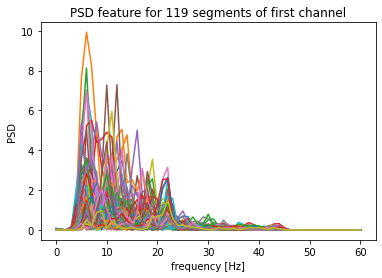

In [15]:
#calculate PSD of all channels using welch method
psd_origin, f = mne.time_frequency.psd_welch(raw, fmin=0, fmax=60, n_fft=128, n_overlap=64, n_per_seg=128, picks='all', window='hann', average=None, verbose=None)# average='mean' or None
print(psd_origin.shape, f.shape) # (12, 61, 125) (61,)
plt.plot(f, psd_origin[0]) # first channel psd of 125 segments
plt.title("PSD feature for 119 segments of first channel")
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD')
plt.show()

In [28]:
#comparing original and standardized data
standardised_data = standardize(single_data, 1)

print(np.amax(single_data)) # max value
print(np.amin(single_data)) # min value
print(np.amax(standardised_data)) # max value
print(np.amin(standardised_data)) # min value

33.46697829071114
-31.335874596603272
8.319613243657404
-7.789838539676195


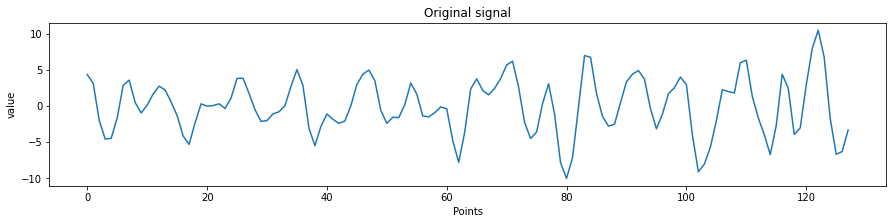

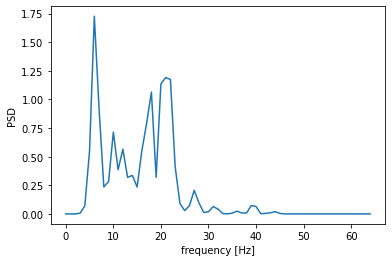

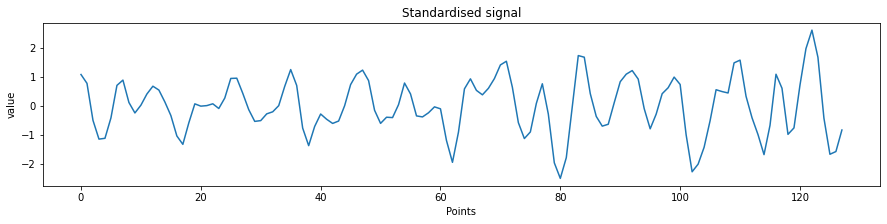

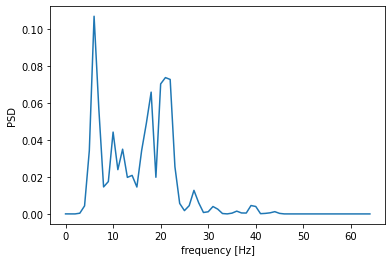

In [29]:
nth = 10
plt.figure(figsize=(15, 3))
plt.plot(single_data[0][nth*128:nth*128+128]) # first trial first channel
plt.title("Original signal")
plt.xlabel('Points')
plt.ylabel('value')
plt.show()

f, Pxx_den = signal.welch(single_data[0][nth*128:nth*128+128], fs=128, window='hann', nperseg = 128, noverlap=64)
plt.plot(f, Pxx_den)
plt.ylim()
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD')
plt.show()

plt.figure(figsize=(15, 3))
plt.plot(standardised_data[0][nth*128:nth*128+128])
plt.title("Standardised signal")
plt.xlabel('Points')
plt.ylabel('value')
plt.show()

f, Pxx_den = signal.welch(standardised_data[0][nth*128:nth*128+128], fs=128, window='hann', nperseg = 128, noverlap=64)
plt.plot(f, Pxx_den)
plt.ylim()
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD')
plt.show()

In [1]:
#Compare original signal and reconstructed signal
autoencoder = keras.models.load_model("../Results/autoencoder_model/autoencoder_model_test_fold_1")
temp = data[:2] # first two trial
data_ = []
for t in temp:
    data_.append(standardize(t, 1))
print(np.amax(data_[0])) # max value
print(np.amin(data_[0])) # min value
8.3196132436574
-7.789838539676193
data_ = np.array(data_)
data_vector = vector_transform(data_)
print(data_vector.shape)
data_reconstructed_vector = autoencoder.predict(data_vector)
data_reconstructed = inverse_vector_transform(data_reconstructed_vector) 
data_reconstructed.shape
(15360, 32)
(2, 32, 7680)
nth = 10
plt.figure(figsize=(15, 3))
plt.plot(data_[0][0][nth*128:nth*128+128]) # first trial first channel
plt.title("Original signal")
plt.xlabel('Points')
plt.ylabel('value')
plt.show()

plt.figure(figsize=(15, 3))
plt.plot(data_reconstructed[0][0][nth*128:nth*128+128])
plt.title("Reconstructed signal")
plt.xlabel('Points')
plt.ylabel('value')
plt.show()

NameError: name 'keras' is not defined